# **INTRODUCTION**
This is the second part of my TTC Subway Delay project.

**Dataset**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import textwrap
import calendar

In [6]:
df_master = pd.read_excel('/Users/emmandeguzman/Documents/Data Projects/TTC Delay Dataset/df_master.xlsx')
df_master

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,station_clean,line_clean,datetime,delay_cause,delay_category
0,2024-01-01,02:00,Monday,SHEPPARD STATION,MUI,0,0,N,YU,5491,Sheppard-Yonge,Lines 1 and 4 Shared,2024-01-01 02:00:00,Injured or ill Customer (On Train) - Transported,Passenger Related
1,2024-01-01,02:00,Monday,DUNDAS STATION,MUIS,0,0,N,YU,0,Dundas,Line 1 Yonge-University,2024-01-01 02:00:00,Injured or ill Customer (In Station) - Transpo...,Passenger Related
2,2024-01-01,02:08,Monday,DUNDAS STATION,MUPAA,4,10,N,YU,6051,Dundas,Line 1 Yonge-University,2024-01-01 02:08:00,Passenger Assistance Alarm Activated - No Trou...,Passenger Related
3,2024-01-01,02:13,Monday,KENNEDY BD STATION,PUTDN,10,16,E,BD,5284,Kennedy,Lines 2 and 3 Shared,2024-01-01 02:13:00,Debris At Track Level - Uncontrollable,Fortuitous Event
4,2024-01-01,02:22,Monday,BLOOR STATION,MUPAA,4,10,N,YU,5986,Bloor-Yonge,Lines 1 and 2 Shared,2024-01-01 02:22:00,Passenger Assistance Alarm Activated - No Trou...,Passenger Related
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214456,2017-04-30,19:50,Sunday,BLOOR DANFORTH SUBWAY,MUO,0,0,NaN,BD,0,Bloor-Yonge,Lines 1 and 2 Shared,2017-04-30 19:50:00,Miscellaneous Other,Undefined
214457,2017-04-30,20:25,Sunday,WARDEN STATION,SUDP,4,8,W,BD,5107,Warden,Line 2 Bloor-Danforth,2017-04-30 20:25:00,Disorderly Patron,Passenger Related
214458,2017-04-30,20:29,Sunday,KEELE STATION,SUROB,0,0,NaN,BD,0,Keele,Line 2 Bloor-Danforth,2017-04-30 20:29:00,Robbery,Passenger Related
214459,2017-04-30,22:00,Sunday,YONGE UNIVERSITY LINE,MUO,0,0,NaN,YU/BD,0,Bloor-Yonge,Lines 1 and 2 Shared,2017-04-30 22:00:00,Miscellaneous Other,Undefined


# **EXPLORATORY DATA ANALYSIS**

## Daily Delay Occurrences

Delay Occurrences is the count or number of recorded delays in a given time period.

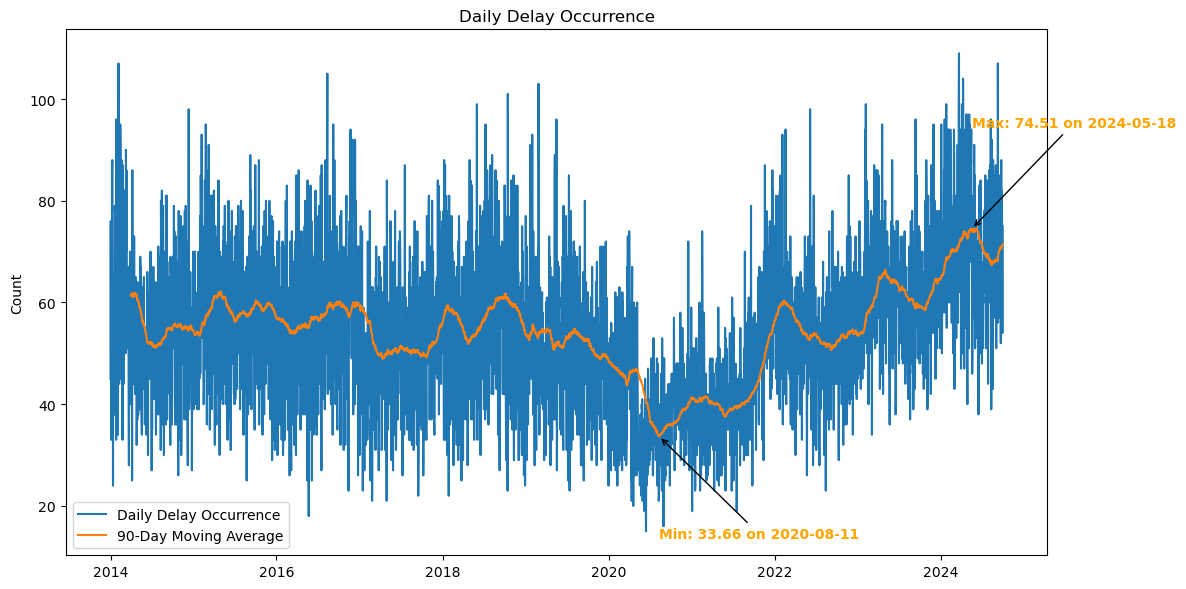

In [48]:
# group by data and count the delay occurrences
daily_delay_occurrence = df_master.groupby('Date')['Min Delay'].count().reset_index()
# compute the 90-day moving average
daily_delay_occurrence['MA90'] = daily_delay_occurrence['Min Delay'].rolling(window = 90).mean()

# create the line chart
plt.figure(figsize = (12,6))
plt.plot(daily_delay_occurrence['Date'], daily_delay_occurrence['Min Delay'], label = 'Daily Delay Occurrence')
plt.plot(daily_delay_occurrence['Date'], daily_delay_occurrence['MA90'], label = '90-Day Moving Average')
plt.title('Daily Delay Occurrence')
plt.ylabel('Count')

# annotate max values
max_date = daily_delay_occurrence.loc[daily_delay_occurrence['MA90'].idxmax(), 'Date']
max_delay = daily_delay_occurrence['MA90'].max()
plt.annotate(f'Max: {max_delay:.2f} on {max_date.strftime("%Y-%m-%d")}',
             xy = (max_date, max_delay), 
             xytext = (max_date, max_delay + 20),
             arrowprops = dict(arrowstyle = '->'), 
             fontsize = 10, 
             color = 'orange', 
             fontweight = 'bold')

# annotate min values
min_date = daily_delay_occurrence.loc[daily_delay_occurrence['MA90'].idxmin(), 'Date']
min_delay = daily_delay_occurrence['MA90'].min()
plt.annotate(f'Min: {min_delay:.2f} on {min_date.strftime("%Y-%m-%d")}',
             xy = (min_date, min_delay), 
             xytext = (min_date, min_delay - 20),
             arrowprops = dict(arrowstyle = '->'), 
             fontsize = 10, 
             color = 'orange', 
             fontweight = 'bold')

plt.legend()
plt.tight_layout()
plt.show()

The number of delays markedly decreased during the pandemic period, from the first quarter of 2020 to the end of 2021. Notably, post-pandemic averages saw an increasing trend, which mean that delays have been getting more frequent compared to pre-pandemic trends.

One important thing to note here, however, is that the dataset includes delay instances that lasted for less than a minute. The TTC marks these as delay occurrences even if they lasted for only several seconds, such as whenever the train has to slow its speed due to 'Miscellaneous' reasons. Therefore, the increasing occurrences might not necessarily mean that TTC's operations are getting worse.

The increasing trend post-pandemic in itself is inconclusive, as this may also indicate better recording practices by TTC from a data collection perspective.

## Daily Delay Duration

Delay Duration is the sum of the length (duration) of recorded delays, as recorded under the 'Min Delay' column of the data frame, in a given time period.

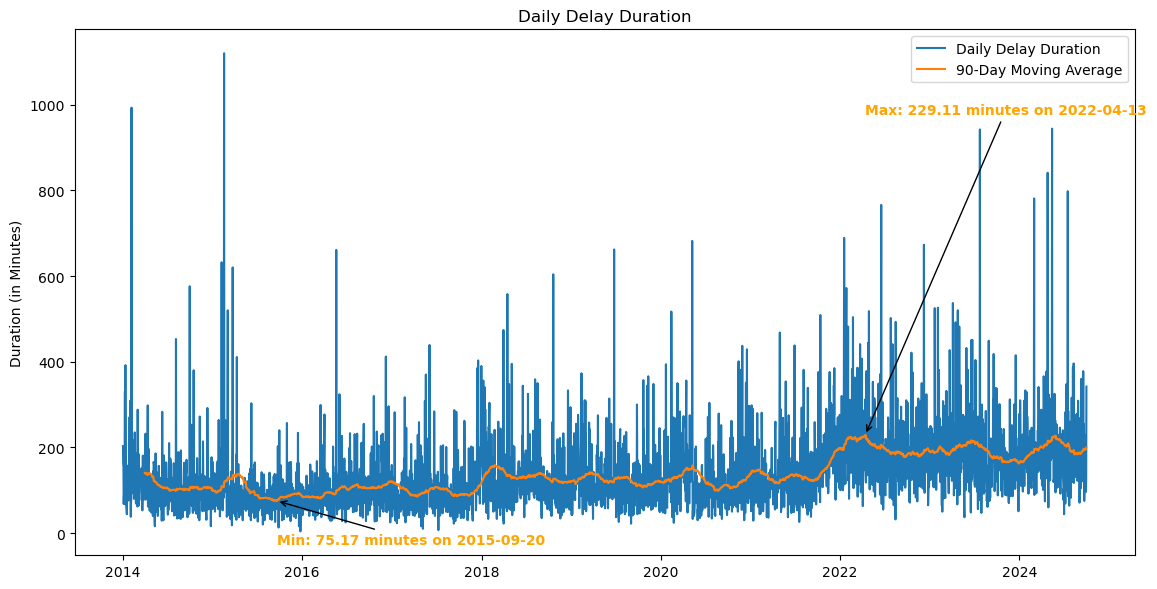

In [64]:
# group by data and count the delay occurrences
daily_delay_duration = df_master.groupby('Date')['Min Delay'].sum().reset_index()
# compute the 90-day moving average
daily_delay_duration['MA90'] = daily_delay_duration['Min Delay'].rolling(window = 90).mean()

# create the line chart
plt.figure(figsize = (12,6))
plt.plot(daily_delay_duration['Date'], daily_delay_duration['Min Delay'], label = 'Daily Delay Duration')
plt.plot(daily_delay_duration['Date'], daily_delay_duration['MA90'], label = '90-Day Moving Average')
plt.title('Daily Delay Duration')
plt.ylabel('Duration (in Minutes)')

# annotate max values
max_date = daily_delay_duration.loc[daily_delay_duration['MA90'].idxmax(), 'Date']
max_delay = daily_delay_duration['MA90'].max()
plt.annotate(f'Max: {max_delay:.2f} minutes on {max_date.strftime("%Y-%m-%d")}',
             xy = (max_date, max_delay), 
             xytext = (max_date, max_delay + 750),
             arrowprops = dict(arrowstyle = '->'), 
             fontsize = 10, 
             color = 'orange', 
             fontweight = 'bold')

# annotate min values
min_date = daily_delay_duration.loc[daily_delay_duration['MA90'].idxmin(), 'Date']
min_delay = daily_delay_duration['MA90'].min()
plt.annotate(f'Min: {min_delay:.2f} minutes on {min_date.strftime("%Y-%m-%d")}',
             xy = (min_date, min_delay), 
             xytext = (min_date, min_delay - 100),
             arrowprops = dict(arrowstyle = '->'), 
             fontsize = 10, 
             color = 'orange', 
             fontweight = 'bold')

plt.legend()
plt.tight_layout()
plt.show()


We see a more conclusive observation here: total delays per day have been lasting longer.

An escalation in the 90-day MADDT was seen in late 2017, which plateaued from early 2018 to the first quarter of 2020. The beginning of the Covid-19 pandemic in the second quarter of 2020 reduced delay durations because of limited subway operations due to lockdowns. However, upon reopening of the economy sometime in late 2021, 90-day MADDT began ascending and peaked on February 12, 2022 at 229.11 minutes (3.8 hours) on a single day. The 90-day MADDT plateaued once more after this date, notably at a higher level compared to that during the pandemic and pre-pandemic periods.

## Time of Delay

Total of delay durations by minute.

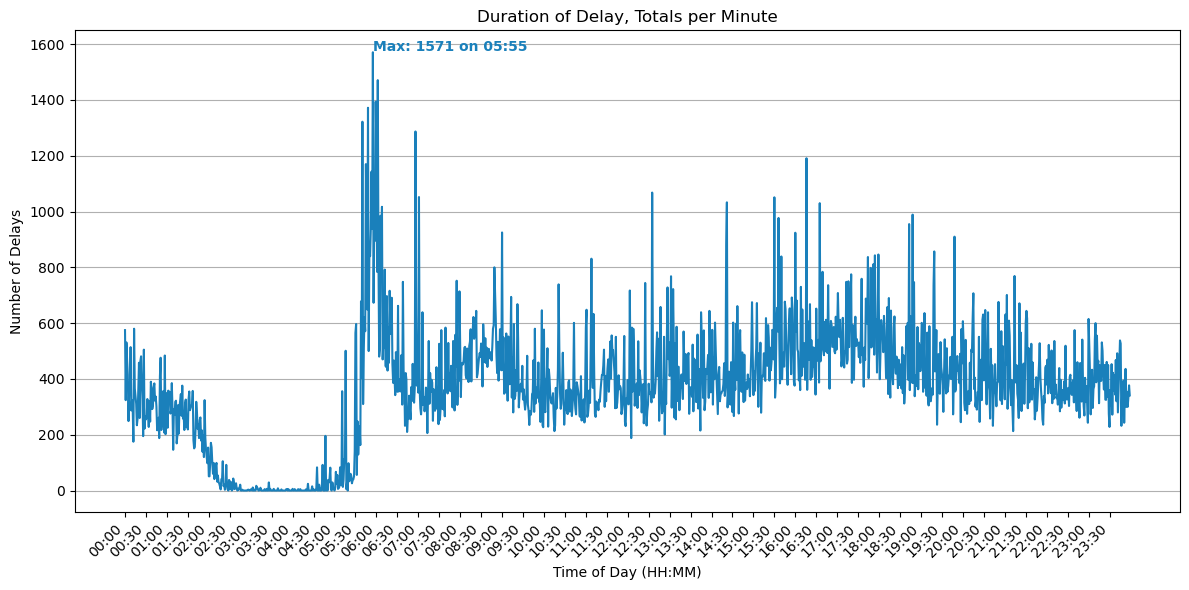

In [13]:
delay_duration_per_minute = df_master.groupby('Time')['Min Delay'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(delay_duration_per_minute['Time'], delay_duration_per_minute['Min Delay'], color='#1a80bb')

# maximum data annotation
max_time = delay_duration_per_minute.loc[delay_duration_per_minute['Min Delay'].idxmax(), 'Time']
max_delay = delay_duration_per_minute['Min Delay'].max()
plt.annotate(f'Max: {max_delay} on {max_time}',
             xy = (max_time, max_delay), xytext = (max_time, max_delay + 5),
             fontsize = 10, color = '#1a80bb', fontweight = 'bold')

plt.title('Duration of Delay, Totals per Minute')
plt.xlabel('Time of Day (HH:MM)')
plt.xticks(delay_duration_per_minute['Time'][::30], rotation=45, ha='right')
plt.ylabel('Number of Delays')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

When delay durations are totaled per minute, 05:55 (5:55 am) had the longest delays. This is a critical time for TTC commuters as this may represent a time when people are on their way to their workplaces.

## Delay Causes

One of the primary objectives of this paper is to determine whether we can improve the efficiency and reliability of the TTC Subway System. As shown previously, there are 200 delay causes identified by the TTC in its excel file (they separated the delay causes between Lines 1, 2, and 4, and Line 3; a number of causes are identical between them), out of which 143 were present in the cleaned dataset. This poses a huge problem in our data analysis.

In [16]:
grouped_delay_causes = df_master.groupby('delay_cause').agg(
  total_occurrence = ('Min Delay', 'count'),
  delay_duration = ('Min Delay', 'sum'),
).reset_index()
grouped_delay_causes['average_delay'] = grouped_delay_causes['delay_duration'] / grouped_delay_causes['total_occurrence']
grouped_delay_causes

,delay_cause,total_occurrence,delay_duration,average_delay
0,ATC Operator Related,342,1467,4.289474
1,ATC Project,3302,15434,4.674137
2,ATC RC&S Equipment,124,644,5.193548
3,ATC Signals Other,54,132,2.444444
4,Air Conditioning,361,1518,4.204986
...,...,...,...,...
138,Work Refusal,221,786,3.556561
139,Work Vehicle,153,1993,13.026144
140,Work Zone Problems - Signals,105,562,5.352381
141,Work Zone Problems - Track,581,6020,10.361446


In [17]:
# for a consistent color-scheme per category, we're creating a dictionary here
colors = {'Personnel Related': 'red',
          'Equipment Related': 'orange',
          'Passenger Related': 'green',
          'Fortuitous Event': 'purple',
          'Undefined': 'gray'}

In [18]:
plt.figure(figsize=(15, 10))
for category, color in colors.items():
    subset = grouped_delay_causes[grouped_delay_causes['delay_cause'].apply(lambda x: categorize_delay(x) == category)]
    plt.scatter(subset['total_occurrence'],
                subset['delay_duration'],
                s = subset['average_delay'] * 10,
                alpha = 0.6,
                label = category,
                c = color)

for i, row in grouped_delay_causes[
    (grouped_delay_causes['total_occurrence'] > 4000) |
    (grouped_delay_causes['delay_duration'] > 20000)
    ].iterrows():
    plt.annotate(row['delay_cause'], (row['total_occurrence'], row['delay_duration']), fontsize=8)

plt.title('Delay Causes')
plt.xlabel('Total Delay Occurrences')
plt.ylabel('Total Delay Duration (minutes)')
plt.xticks(rotation = 0, ha = 'right')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'categorize_delay' is not defined

<Figure size 1500x1000 with 0 Axes>